In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Podział na podzbiory
from sklearn.model_selection import train_test_split

# Normalizacja danych
from sklearn.preprocessing import MinMaxScaler

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Bayes naiwny Gaussowski
from sklearn.naive_bayes import GaussianNB

In [83]:
df = pd.read_csv('diabetes.csv')

# Podstawowa obróbka i wyświetlanie
# df.head(n=5)              # - wyświetla pierwsze n rekordów tabeli wraz z nazwami kolumn (defaultowo n=5)
# df["BMI"][3]              # - wyświetla wartość z kolumny "BMI" dla rekordu z indeksem 3
# df.describe()             # - analizuje dane z tabeli, wyświetla średnią, medianę, min, max, itp. dla każdej kolumny
# df.info()                 # - wyświeta informacje o rekordach - typ danych, ilość non-nulli itp.
# df.corr()                 # - wyświetla macierz korelacji - związki pomiędzy kolumnami - im więcej, tym dane bardziej powiązane
#                               korelacja Pearsona: blisko (-1) -> odwrotna proporcjonalność, blisko (1) -> proporcjonalność
#                               Co to oznacza? prawdopodobnie którąś z kolumn o wysokim współcznynniku można wyjebać,
#                               nie tracąc na skuteczności, a zyskując na wydajności (czasie)
# print(df.isnull().sum())  # - wyświetla ilość wartości nullowych w każdej kolumnie
# df.dropna(inplace=True)   # - wywala rekordy zawierające wartości nullowe
# df.columns.tolist()       # - wrzuca nazwy kolumn do listy, przydatne do pisania własnych algorytmów
# df.drop("Outcome", axis=1, inplace=True)  # - wywala kolumnę "Outcome" z oryginału tabeli
# m_df = df.drop("Outcome", axis=1)         # - tworzy kopię tabeli bez kolumny "Outcome", nie zmienia oryginału
# m_df = df.pop("Outcome")  # - wyrzuca kolumnę "Outcome" z df i zapisuje ją do m_df
# df.iloc[1]                # - zwraca rekord o indeksie numerycznym, równym 1
# df.loc["abc"]             # - zwraca rekord o indeksie tekstowym, równym "abc"




Wykresiki i kolorowanki

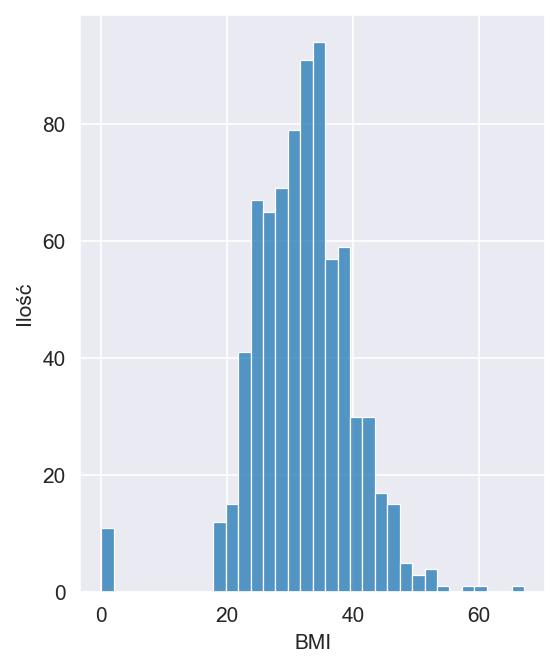

In [84]:
plt.figure(figsize=(4, 5), dpi=150)         # - określenie rozmiaru generowanego wykresu (w calach)
sns.histplot(data=df, x='BMI')              # - tworzenie wykresu na podstawie kolumny 'BMI' z tabeli df
# sns.histplot(df['BMI'])                   # - alternatywa dla ^
plt.xlabel("BMI")           # - etykieta osi X
plt.ylabel("Ilość")         # - etykieta osi Y
plt.show()                  # - wyświetlenie wykresu

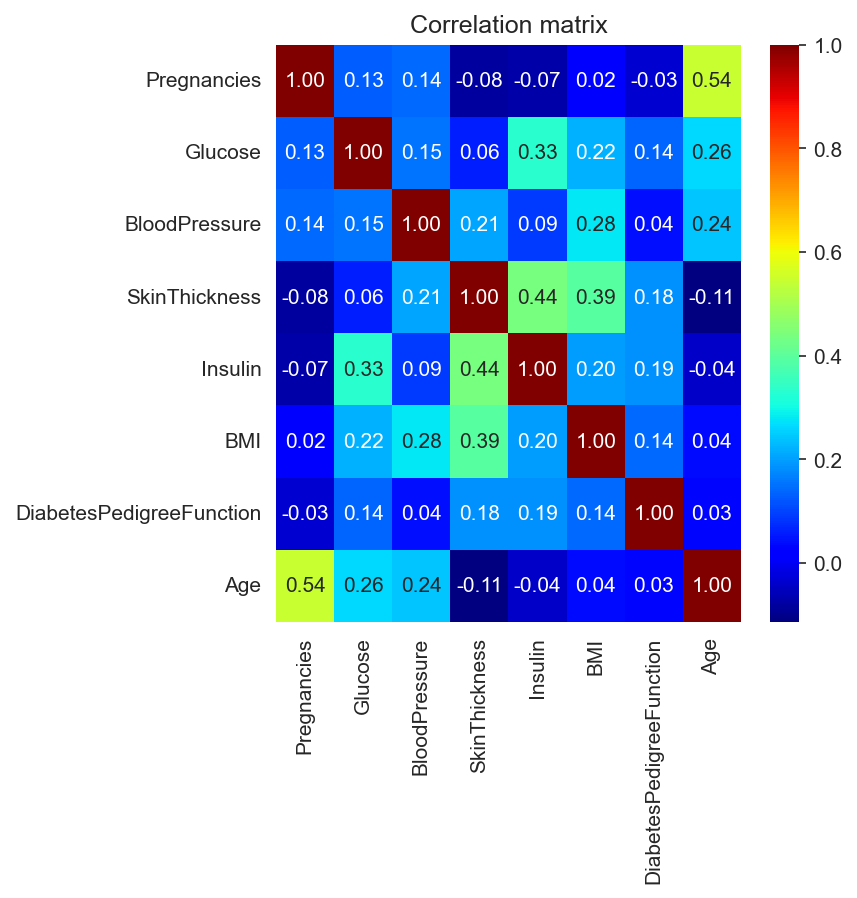

In [85]:
plt.figure(figsize=(5,5), dpi=150)
sns.heatmap(df.drop("Outcome", axis=1).corr(), annot=True, cmap="jet", fmt=".2f")
plt.title("Correlation matrix")
plt.show()

Normalizowanie danych

In [86]:
# Podejście biblioteczne
# from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
df_libscaled = pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
# df_libscaled.head()


# Podejście odważne - implementacja minmax scaler
cols_to_normalize = df.drop(['Outcome'], axis=1).columns    # Zakomentować jeżeli ma normalizować także Outcome
df_scaled = df.copy()
for col in cols_to_normalize:
    xmin = df_scaled[col].min()
    xmax = df_scaled[col].max()
    df_scaled[col] = (df_scaled[col] - xmin) / (xmax - xmin)
# df_scaled.head()


Dzielenie danych na zbiory

In [87]:
# Podejście biblioteczne
# from sklearn.model_selection import train_test_split
y = df.pop("Outcome")
X = df
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Podejście odważne
def my_train_test_split(X, y, test_size=0.3, random_state=None):
    # Ziarno losowości
    if random_state is not None:
        np.random.seed(random_state)
  
    test_size = int(test_size * len(X))                     # Rozmiar zbioru testowego (liczba całkowita)
    
    shuffled_indices = np.random.permutation(X.index)       # Przetasowanie indeksów zbioru
    indices_train = shuffled_indices[test_size:]            # Podział indeksów na podzbiory: treningowy i testowy
    indices_test = shuffled_indices[:test_size]
    
    X_train = X.iloc[indices_train]             # Utworzenie podzbiorów na podstawie ^ indeksów
    X_test = X.iloc[indices_test]
    y_train = y.iloc[indices_train]
    y_test = y.iloc[indices_test]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = my_train_test_split(X, y, test_size=0.3)

In [88]:
def calculate_accuracy(y_test, y_pred):
    return sum(y_test == y_pred) / len(y_test)

Klasyfikator KNN - biblioteczny

In [89]:
# from sklearn.neighbors import KNeighborsClassifier
knn_lib = KNeighborsClassifier(14)          # Tworzenie obiektu klasyfikatora - parametr to liczba sąsiadów w klasyfikatorze
knn_lib.fit(X_train, y_train)               # Dopasowanie (trenowanie) zbiorów treningowych
knn_score = knn_lib.score(X_test, y_test)   # Ocena wydajności klasyfikatora
print(knn_score)

0.7739130434782608


Klasyfikator KNN - krew, pot i łzy

In [90]:
class KNN:
    def __init__(self, k_neighbors=3):
        self.k_neighbors = k_neighbors
        
    # Metryka obliczania odległości
    # W tym przypadku jest to odległość euklidesowa -> na kolosie może być potrzeba zmiany sposobu liczenia
    def __distance_metric(self, point, data):
        return np.sqrt(np.sum((data - point) ** 2, axis=1))        
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        predictions = []
        
        for x in X_test.values:
            # Wyliczanie odległości pomiędzy X'ami testowanymi a X'ami treningowymi
            distances = self.__distance_metric(x, self.X_train)
            
            # Sortowanie odległości, wybór k najmniejszych wartości (indeksów tych wartości)
            indices = np.argsort(distances)[:self.k_neighbors]
            
            # Plebiscyt - dodanie do grupy z największą liczbą głosów
            labels = [self.y_train.iloc[i] for i in indices]
            result = max(set(labels), key=labels.count)
            
            # Dodanie do predictions
            predictions.append(result)
        
        return predictions
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = sum(y_test == y_pred) / len(y_test)
        return accuracy

my_knn = KNN(14)
my_knn.fit(X_train, y_train)
print(my_knn.score(X_test, y_test))
# Wynik taki sam jak algorytm biblioteczny -> wielce prawdopodobne, że działa
        

0.7739130434782608


Bayes naiwny Gaussowski - z biblioteki

In [91]:
# from sklearn.naive_bayes import GaussianNB

nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)
print(f"{calculate_accuracy(y_test, y_pred)} | {nb_classifier.score(X_test, y_test)}")


0.7695652173913043 | 0.7695652173913043


Bayes naiwny Gaussowski - droga ku zagładzie

In [92]:
class NaiveBayes():
    def __init__(self):
        self.mean = {}              # Średnie klas
        self.var = {}               # Wariancje klas
        self.class_prior = {}       # Prawdopodobieństwa prior klas - prawdopodobieństwo wylosowania elementu klasy z całości tabeli
        
    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)                   # Znalezienie unikalnych wartości y -> ilość różnych klas
        for cls in self.classes:
            X_c = X_train[y_train == cls]                   # Utworzenie tymczasowego podzbioru X'ów należących do tej Fosamej klasy
            self.class_prior[cls] = len(X_c)/len(X_train)   # Obliczenie prawdopodobieństwa prior
            self.mean[cls] = np.mean(X_c, axis=0)           # Obliczenie średniej wszystkich rekordów dla każdej z kolumn (axis=0)
            self.var[cls] = np.var(X_c, axis=0)             # Obliczenie wariancji wszystkich rekordów dla każdej z kolumn (axis=0)
            
    def gauss(self, x, mean, var):                          # Funkcja gęstości Gaussa 
        exponent = np.exp(-(x - mean) ** 2 / (2 * var))
        return 1/np.sqrt(2 * np.pi * var) * exponent
            
    def calculate_posterior(self, x):
        posteriors = {}
        for cls in self.classes:
            # Normalizacja funkcją logarytmiczną - przyspiesza obliczenia
            prob = np.sum(np.log(self.gauss(x, self.mean[cls], self.var[cls])))
            posteriors[cls] = np.log(self.class_prior[cls]) + prob
        return posteriors
            
    def predict(self, X_test):
        predictions = []
        for x in X_test.values:
            prob = self.calculate_posterior(x)              # Obliczenie posteriora dla każdej z klas
            predictions.append(max(prob, key=prob.get))     # Dodanie x do klasy o najwyższym współczynniku posterior
        return predictions
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = sum(y_test == y_pred) / len(y_test)
        return accuracy
    
    
my_NaiveBayes = NaiveBayes()
my_NaiveBayes.fit(X_train, y_train)
my_NaiveBayes.score(X_test, y_test)

0.7695652173913043

Zbiory miętkie - wnioskowanie z zajęć

In [93]:
# świeże, mrożone, ostre, słodkie, zielone, czerwone, lokalne, tropikalne, liściaste, bulwowe
warzywniak = {
    "papryka_ostra":    [1, 0, 1, 0, 0, 1, 1, 0, 0, 0],
    "ziemniaki":        [0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
    "rzodkiewka":       [1, 0, 1, 0, 0, 1, 1, 0, 0, 0],
    "mango":            [0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
    "kapusta":          [1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
    "ogur":             [1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
    "tropikalny_ogur":  [1, 0, 1, 1, 1, 1, 0, 1, 0, 0]

}

# klienci
# A={świeże, ostre, czerwone},
# B={mrożone, zielone, słodkie, liściaste},
# C={świeże, zielone, czerwone, słodkie}.
klientA = (.5, 0, .2, 0, 0, .3, 0, 0, 0, 0)
klientB = (0, .2, 0, .4, .15, 0, 0, 0, .25, 0)
klientC = (.2, 0, 0, .15, .45, .2, 0, 0, 0)
        
def wnioskuj(klient):
    wagi_warzyw = []
    
    for warzywo, cechy_warzywa in warzywniak.items():
        # Oblicz iloczyn elementów listy cech_warzywa i klient
        waga_warzywa = sum(c * k for c, k in zip(cechy_warzywa, klient))
        wagi_warzyw.append(waga_warzywa)
    
    # Znajdź indeks maksymalnej wagi_warzyw
    indeks_maksimum = max(range(len(wagi_warzyw)), key=wagi_warzyw.__getitem__)
    
    # Zwróć nazwę warzywa na podstawie indeksu maksymalnej wagi
    return list(warzywniak.keys())[indeks_maksimum]


print(f"Klient A: {wnioskuj(klientA)}")
print(f"Klient B: {wnioskuj(klientB)}")
print(f"Klient C: {wnioskuj(klientC)}")


Klient A: papryka_ostra
Klient B: mango
Klient C: tropikalny_ogur
